# Session 2: Contextual Word Embeddings with BERT

In this session, we explore **contextual representations** of words using models like **ELMo** and **BERT**. These models generate embeddings that depend on a word's context, unlike static embeddings such as Word2Vec or GloVe.

We'll use real-world sentences from a dataset to demonstrate how contextual embeddings distinguish between different meanings of the same word.

## 📂 Dataset: Semantic Similarity from STS Benchmark

We'll use a small sample of sentence pairs from the [STS Benchmark dataset](https://huggingface.co/datasets/stsb_multi_mt) available via Hugging Face Datasets. This dataset contains pairs of sentences and human-assigned similarity scores.

We'll compare how static and contextual embeddings interpret these sentences.

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
!pip install transformers datasets torch gensim scikit-learn --quiet

In [13]:
from datasets import load_dataset

# Load a small portion of the STS dataset
dataset = load_dataset('stsb_multi_mt', name='en', split='train[:20]')
dataset = dataset.shuffle(seed=42)
dataset = dataset.select_columns(['sentence1', 'sentence2'])
dataset.to_pandas().head()

,sentence1,sentence2
0,A dog is trying to get bacon off his back.,A dog is trying to eat the bacon on its back.
1,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.
2,A man is running on the road.,A panda dog is running on the road.
3,The man is playing the piano.,The man is playing the guitar.
4,A man is playing a flute.,A man is playing a bamboo flute.


## 🔍 Comparing Word2Vec and BERT Embeddings

We'll compute the cosine similarity between sentence embeddings produced by Word2Vec and BERT for the same sentence pairs.

In [14]:
import gensim.downloader as api
import shutil
import os

# Path to Gensim's data folder (default)
gensim_dir = os.path.join(os.path.expanduser('~'), 'gensim-data', 'glove-wiki-gigaword-50')

# Remove corrupted data folder (if it exists)
if os.path.exists(gensim_dir):
    shutil.rmtree(gensim_dir)

# Retry download
word2vec = api.load('glove-wiki-gigaword-50')


[==================================================] 100.0% 66.0/66.0MB downloaded


In [15]:
def sentence_embedding_w2v(sentence):
    words = sentence.lower().split()
    valid_words = [word for word in words if word in word2vec]
    if not valid_words:
        return np.zeros(50)
    return np.mean([word2vec[word] for word in valid_words], axis=0)


In [16]:
# Compute similarity scores for Word2Vec
w2v_scores = []
for row in dataset:
    emb1 = sentence_embedding_w2v(row['sentence1'])
    emb2 = sentence_embedding_w2v(row['sentence2'])
    score = cosine_similarity([emb1], [emb2])[0][0]
    w2v_scores.append(score)

w2v_scores[:5]

[0.9755332, 0.98875314, 0.96923137, 0.99999994, 0.98199517]

In [17]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [18]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')
model.eval()

def sentence_embedding_bert(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Compute similarity scores for BERT
bert_scores = []
for row in dataset:
    emb1 = sentence_embedding_bert(row['sentence1'])
    emb2 = sentence_embedding_bert(row['sentence2'])
    score = cosine_similarity([emb1], [emb2])[0][0]
    bert_scores.append(score)

bert_scores[:5]

[0.9715182, 0.9647024, 0.9449861, 0.98771226, 0.9863796]

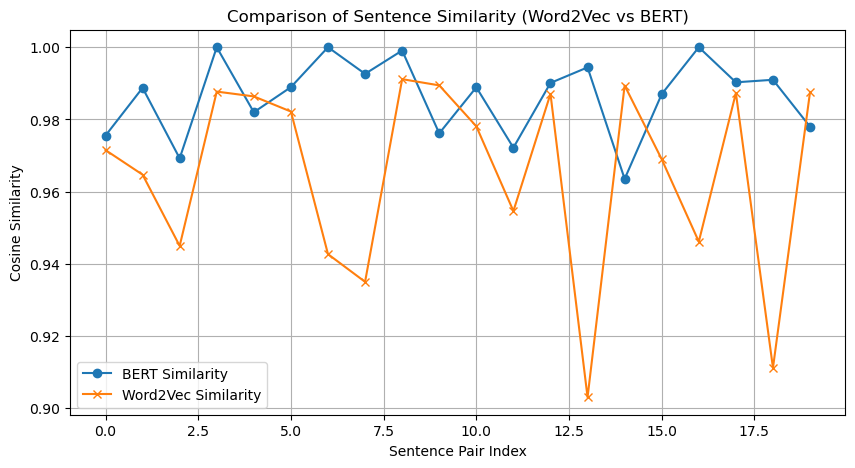

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(w2v_scores, label='BERT Similarity', marker='o')
plt.plot(bert_scores, label='Word2Vec Similarity', marker='x')
plt.title('Comparison of Sentence Similarity (Word2Vec vs BERT)')
plt.xlabel('Sentence Pair Index')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.grid(True)
plt.show()